# K-means clustering of images preprocessed with F. Civilini's pipeline

By Mariana Blanco-Rojas 2024

This notebook runs a k-means clustering algorithm on the JMARS and Kaguya images acquired and preprocessed using F. Civilini's pipeline.
<br>

Overview of the workflow: <br>

#### Protocol 1:
<ul>
    <li> Read and save Kaguya tif file as pkl </li>
    <li> Read pkl data exported from JMARS </li>
    <li> Rotating and flipping JMARS data to match the orientation of Kaguya imagery </li>
    <li> Resizing images </li>
    <li> Flattening data </li>
    <li> Running k-means </li>
    <li> Plotting and saving clustered map </li>

<br>

#### Protocol 2:

_Part 1:_
<ul>
    <li> Read and save Kaguya tif file as pkl </li>
    <li> Flattening data </li>
    <li> Running k-means </li>
    <li> Plotting and saving clustered map </li>

<br>

_Part 2:_
<ul>
    <li> Read pkl data exported from JMARS </li>
    <li> Rotating and flipping JMARS data to match the orientation of Kaguya imagery </li>
    <li> Adding the imagery cluster map from part 1 to the cube of JMARS data </li>
    <li> Resizing images </li>
    <li> Flattening data </li>
    <li> Running k-means </li>
    <li> Plotting and saving clustered map </li>

In [1]:
from scipy.ndimage import zoom
from sklearn.preprocessing import StandardScaler
#from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
#import glob
from matplotlib import cm
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
#from scipy import interpolate
import geopandas as gpd
#from mpl_toolkits.mplot3d import axes3d
from skimage.transform import resize
#import shapely
from matplotlib import ticker
import rasterio
import numpy as np
import pickle
from sklearn.impute import KNNImputer

In [2]:
# Function that resizes the image arrays before adding them to the data cube
def resize_array(array, target_shape):
    if isinstance(array, list):
        array = np.array(array)
    factors = [target_shape[i] / array.shape[i] for i in range(len(target_shape))]
    resized_array = zoom(array, factors, order=1)  # Using linear interpolation
    return resized_array

# Simple function to plot data
def plot_layer(data, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(data, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Function that converts a tif file (in this case the Kaguya TC imagery) to a pkl file
def tif_to_pkl(tif_path, pkl_path):
    with rasterio.open(tif_path) as src:
        data = src.read()
        metadata = src.meta

    # If desired, this prints the shape and type of the data for verification
    #print(f'tif file data shape: {data.shape}')
    #print(f'Read data type: {data.dtype}')
    #print(f'Read metadata: {metadata}')

    tif_data = {
        'data': data,
        'metadata': metadata
    }

    with open(pkl_path, 'wb') as f:
        pickle.dump(tif_data, f)

    print(f'TIFF data has been saved to {pkl_path} as PKL format.')

# Protocol 1:

This code processes the Kaguya and JMARS images simultaneously, and clusters a cube made from all JMARS and Kaguya data available for a given area.

Clustering our data cubes, protocol 1
The directories we are taking data from are: ['/explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/structures/A17/cutdata/']
TIFF data has been saved to /explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/structures/A17/cutdata/raw_A17_kaguya_test.pkl as PKL format.
raw_A17_div-hparam_512ppd_JMARS_interp.pkl has shape: (3, 431, 584)


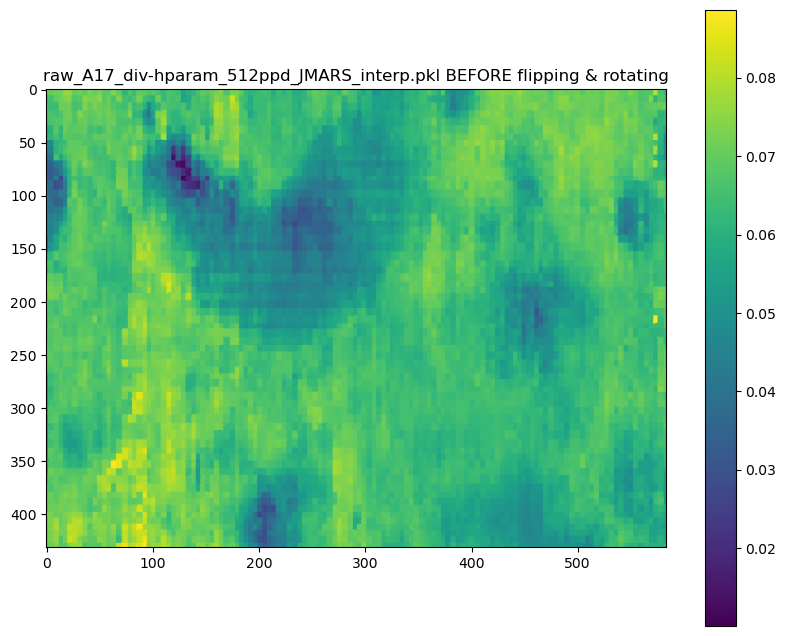

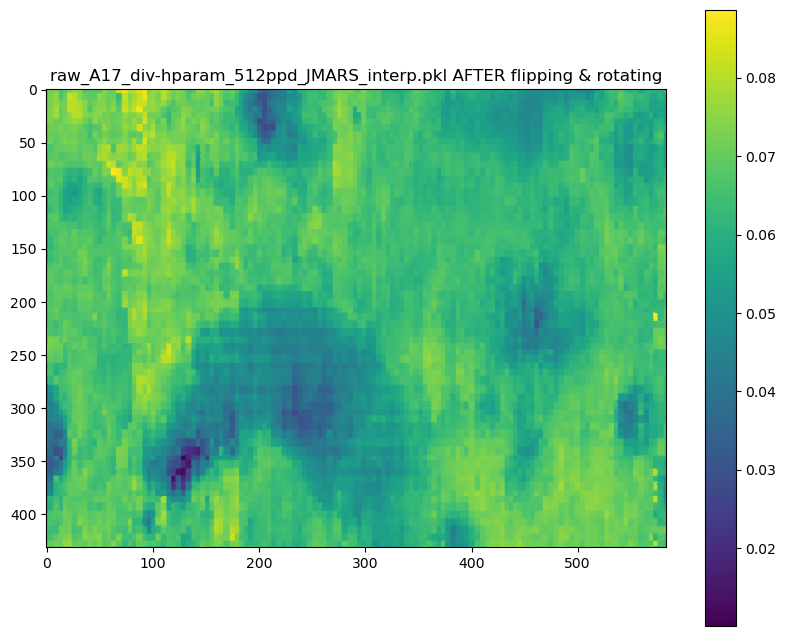

raw_A17_div-rockabun_2048ppd_JMARS_interp.pkl has shape: (3, 1798, 2354)


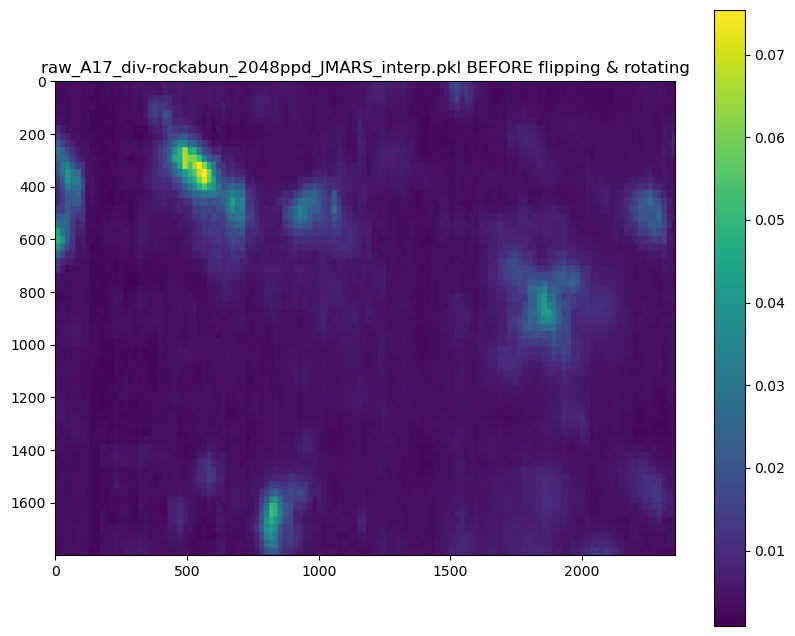

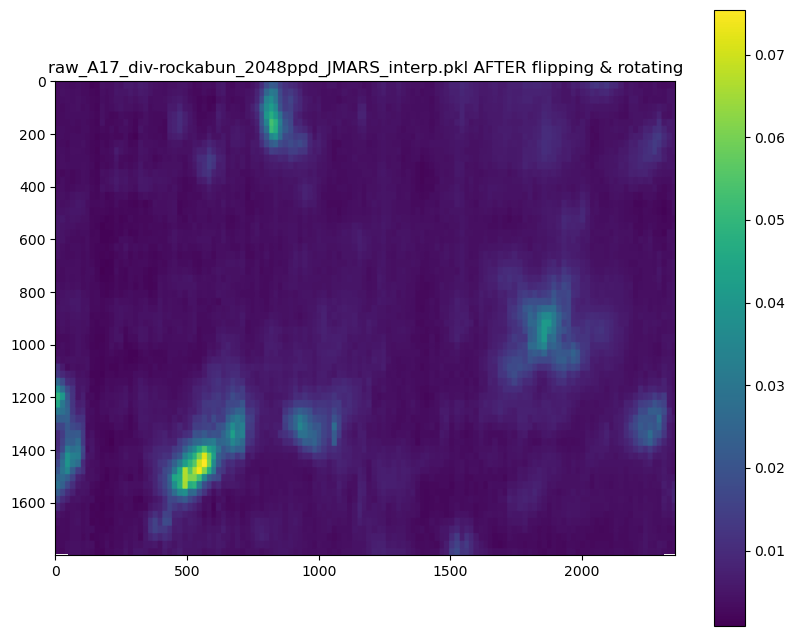

raw_A17_clem-omat_128ppd_JMARS_interp.pkl has shape: (3, 111, 148)


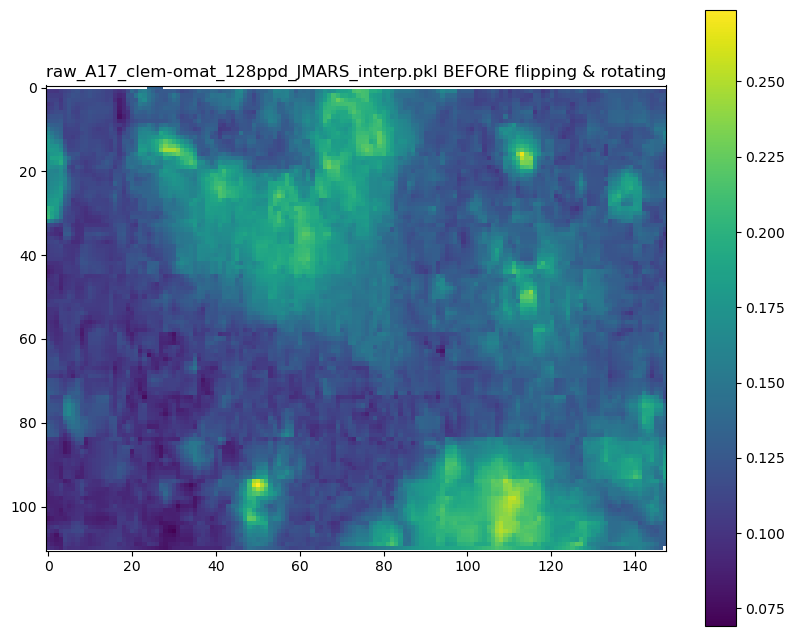

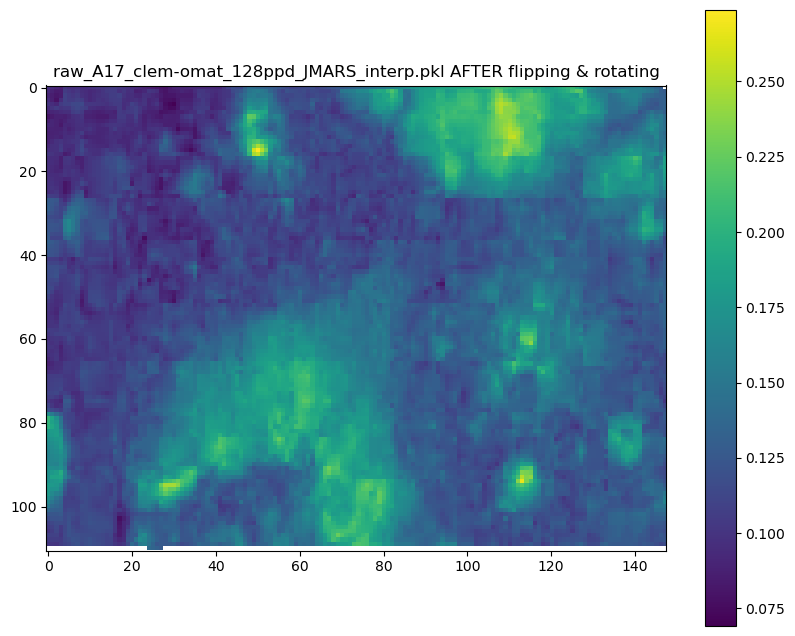

raw_A17_kaguya_test.pkl has shape: (111, 148)


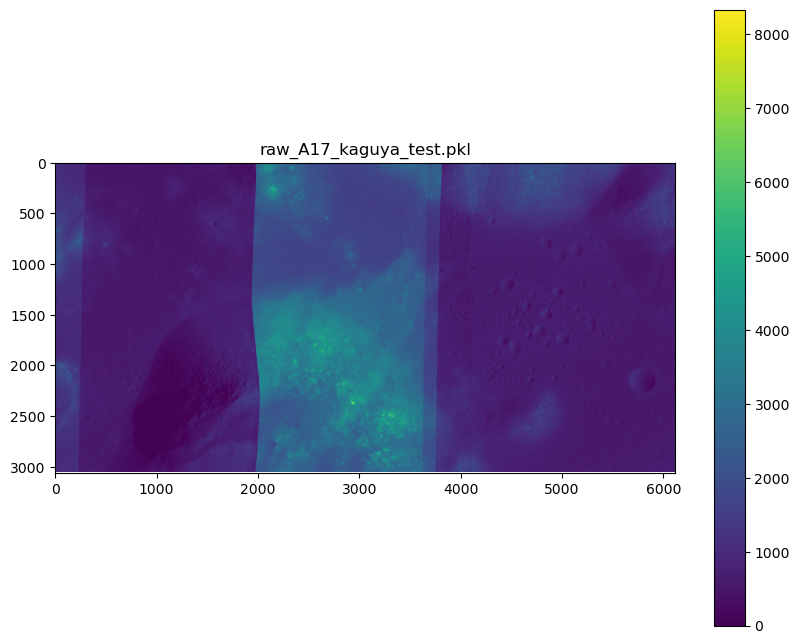

Data cube shape: (4, 3059, 6118, 1)
Made cube of pkl files
NaN values in flattened data before imputation: 169456
NaN values in imputed data: 0
Applying k-means clustering algorithm
Finished clustering


In [3]:
print('Clustering our data cubes, protocol 1')

# Directories where we have our cut JMARS and Kaguya data for the area of interest
directories = ['/explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/structures/A17/cutdata/']
print('The directories we are taking data from are:', directories)
max_shape = (0, 0, 0)
resized_data_all = []
pklcubes = []
pklfile_list = []

# Path for the tif file of the cut Kaguya data
tif_path = '/explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/structures/A17/cutdata/raw_A17_kaguya.tif'

# Path to save the pkl file of the cut Kaguya data
pkl_path = '/explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/structures/A17/cutdata/raw_A17_kaguya_test.pkl' 
tif_to_pkl(tif_path, pkl_path)

for directory in directories:
    # Load the .pkl files from the JMARS data
    for filename in os.listdir(directory):
        if filename.endswith('interp.pkl'):
            with open(os.path.join(directory, filename), 'rb') as f:
                data = pickle.load(f)
                print(filename, 'has shape:', np.shape(data))
                
                # Plotting cut data before flipping and rotating
                plot_layer(data[2][:][:], f'{filename} BEFORE flipping & rotating')
                
                # Rotating JMARS data by 180 degrees. We select to isolate layer 3, the only layer with data
                data = np.rot90(data[2][:][:], 2) 
                # Flipping JMARS data along the y axis
                data = np.fliplr(data)
                
                # Plotting data after it has been flipped and rotated
                plot_layer(data, f'{filename} AFTER flipping & rotating')
                
                pklfile_list.append(data)
                
                # Finding the largest dimension. This is what all arrays will be resized to
                max_shape = tuple(max(s1, s2) for s1, s2 in zip(max_shape, np.shape(data)))

        # Load the .pkl file created from the Kaguya tif file
        if filename.endswith('test.pkl'):
            print(filename, 'has shape:', np.shape(data))
            with open(os.path.join(directory, filename), 'rb') as f:
                data = pickle.load(f)
                data = data['data']
                data = np.squeeze(data)
                plot_layer(data, f'{filename}')

                pklfile_list.append(data)
                
                # Finding the largest dimension. This is what all arrays will be resized to
                max_shape = tuple(max(s1, s2) for s1, s2 in zip(max_shape, np.shape(data)))

    # Resizing all images
    resized_data_list = [resize_array(data, max_shape) for data in pklfile_list]
    resized_data_all.append(resized_data_list)

    # Combining the data into a single data cube 
    pklfile_cube = np.stack(resized_data_all, axis=-1)
    print(f'Data cube shape: {pklfile_cube.shape}')
    pklcubes.append(pklfile_cube)
    print('Made cube of pkl files')

scaled_cubes = []
combined_scaled_data_cubes = []

for cube, directory in zip(pklcubes, directories):
    # Flattening the data cube for clustering
    num_datasets, num_rows, num_cols, _ = cube.shape

    flat_data = cube.reshape(num_datasets * num_rows * num_cols, -1)
    print(f'NaN values in flattened data before imputation: {np.isnan(flat_data).sum()}')

    # This is one way of removing NaNs from data. It takes a very long time to run.
    # imputer = KNNImputer(n_neighbors=3)
    # imputed_data = imputer.fit_transform(flat_data)
    
    # Replacing NaNs in flattened data with 0
    flat_data[np.isnan(flat_data)] = 0
    imputed_data = flat_data
    print(f'NaN values in imputed data: {np.isnan(imputed_data).sum()}')

    imputed_cube = imputed_data.reshape(cube.shape)

    # Standardizing the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(imputed_data)
    scaled_cubes.append(scaled_data)
    combined_scaled_data = np.vstack(scaled_cubes)
    combined_scaled_data_cubes.append(combined_scaled_data)
    
    # Now we apply the k-means clustering
    print('Applying k-means clustering algorithm')
    
    # Number of clusters
    num_clusters = 30
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(scaled_data)
    # Getting the cluster labels
    cluster_labels = kmeans.labels_
    # Reshaping cluster labels back to the original spatial dimensions
    cluster_labels_reshaped = cluster_labels.reshape(num_datasets, num_rows, num_cols)
    print('Finished clustering')

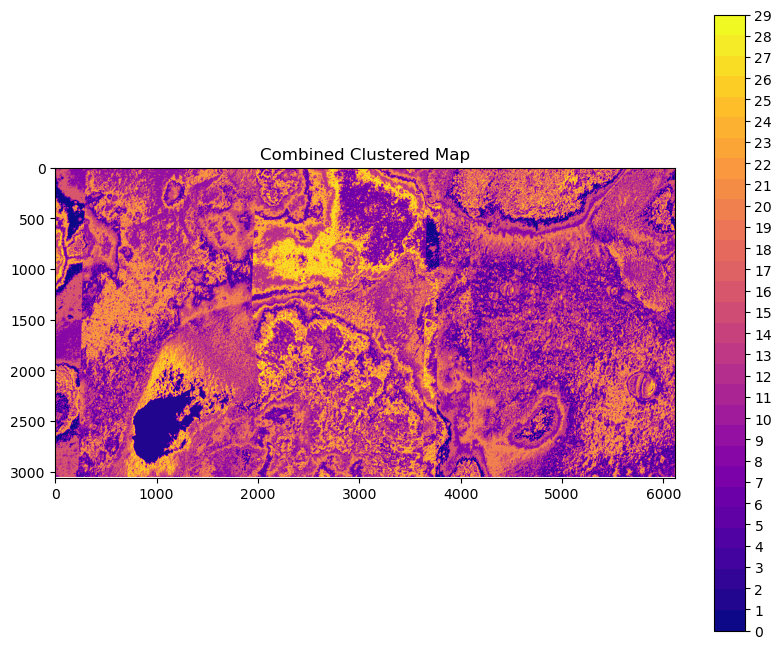

Combined k-means map saved as /explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/kmeans/A17/combined_clustered_map_30Clusters_Protocol1_08-08.png


In [4]:
# Directory where we want to save the resulting clustered map. If it doesn't exist yet, we create it
directory = '/explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/kmeans/A17/'
if not os.path.exists(directory):
    os.makedirs(directory)

# Only plotting the layer of the cluster map that has labels
combined_cluster_map = cluster_labels_reshaped[3][:][:]

# Plotting the 2D k-means map
plt.figure(figsize=(10, 8))
plt.imshow(combined_cluster_map, cmap=plt.cm.get_cmap('plasma', num_clusters))

cb = plt.colorbar()

# Adjust the number of ticks using MaxNLocator
tick_locator = ticker.MaxNLocator(nbins=num_clusters)
cb.locator = tick_locator
cb.update_ticks()

plt.title('Combined Clustered Map')

# Save the plot
output_path = directory + 'combined_clustered_map_30Clusters_Protocol1_08-08.png'
plt.savefig(output_path)
plt.show()
plt.close()
print(f'Combined k-means map saved as {output_path}')

# Protocol 2:
This code processes the Kaguya imagery first, and creates a cluster map using just this imagery. The resulting map is then fed into a data cube with the processed JMARS data.

In [5]:
# This next protocol creates a cluster map of just the Kaguya imagery, which is then fed into the cube with the JMARS data

print('Clustering our data cubes. Protocol 2, part 1')

# Directories where we have our cut JMARS and Kaguya data for the area of interest
directories = ['/explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/structures/A17/cutdata/']
print('The directories we are taking data from are:', directories)
max_shape = (0, 0, 0)
resized_data_all = []
pklcubes = []
pklfile_list = []

# Path for the tif file of the cut Kaguya data
tif_path = '/explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/structures/A17/cutdata/raw_A17_kaguya.tif'

# Path to save the pkl file of the cut Kaguya data
pkl_path = '/explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/structures/A17/cutdata/raw_A17_kaguya_test.pkl'  # Path to save the output pickle file
tif_to_pkl(tif_path, pkl_path)

for directory in directories:
    # Load the .pkl file of the Kaguya data
    for filename in os.listdir(directory):
        
        if filename.endswith('test.pkl'):

            print(filename, 'has shape:', np.shape(data))
            with open(os.path.join(directory, filename), 'rb') as f:
                data = pickle.load(f)
                data = data['data']
                data = np.squeeze(data)

                pklfile_list.append(data)
                max_shape = tuple(max(s1, s2) for s1, s2 in zip(max_shape, np.shape(data)))

    resized_data_list = [resize_array(data, max_shape) for data in pklfile_list]
    resized_data_all.append(resized_data_list)

    # Combine the data into a single data cube, in this case, the cube only has the Kaguya data
    pklfile_cube = np.stack(resized_data_all, axis=-1)
    print(f'Data cube shape: {pklfile_cube.shape}')
    pklcubes.append(pklfile_cube)
    print('Made cube of pkl files')

scaled_cubes = []
combined_scaled_data_cubes = []

for cube, directory in zip(pklcubes, directories):
    # Flattening the data cube for clustering
    num_datasets, num_rows, num_cols, _ = cube.shape

    flat_data = cube.reshape(num_datasets * num_rows * num_cols, -1)
    print(f'NaN values in flattened data before imputation: {np.isnan(flat_data).sum()}')
    
    #imputer = SimpleImputer(strategy='mean')
    # imputer = KNNImputer(n_neighbors=20)
    # imputed_data = imputer.fit_transform(flat_data)
    
    flat_data[np.isnan(flat_data)] = 0
    imputed_data = flat_data
    print(f'NaN values in imputed data: {np.isnan(imputed_data).sum()}')

    imputed_cube = imputed_data.reshape(cube.shape)

    # Standardizing the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(imputed_data)
    scaled_cubes.append(scaled_data)

    combined_scaled_data = np.vstack(scaled_cubes)
    combined_scaled_data_cubes.append(combined_scaled_data)
    

    print('Applying k-means clustering algorithm')
    # Number of clusters
    num_clusters = 30
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(scaled_data)
    # Getting the cluster labels
    cluster_labels = kmeans.labels_
    # Reshaping the cluster labels back to the original spatial dimensions
    cluster_labels_reshaped = cluster_labels.reshape(num_datasets, num_rows, num_cols)
    print('Finished clustering')

Clustering our data cubes. Protocol 2, part 1
The directories we are taking data from are: ['/explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/structures/A17/cutdata/']
TIFF data has been saved to /explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/structures/A17/cutdata/raw_A17_kaguya_test.pkl as PKL format.
raw_A17_kaguya_test.pkl has shape: (3059, 6118)
Data cube shape: (1, 3059, 6118, 1)
Made cube of pkl files
NaN values in flattened data before imputation: 0
NaN values in imputed data: 0
Applying k-means clustering algorithm
Finished clustering


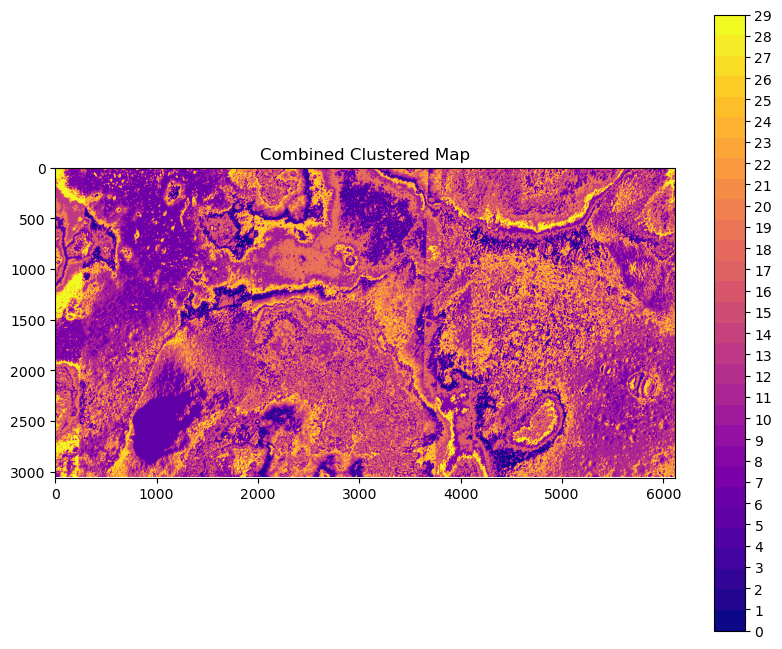

k-means map (only imagery) saved as /explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/kmeans/A17/combined_clustered_map_30Clusters_Protocol2_Part1_08-08.png


In [6]:
# Directory where we want to save the resulting clustered map. If it doesn't exist yet, we create it
directory = '/explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/kmeans/A17/'
if not os.path.exists(directory):
    os.makedirs(directory)

# Only plotting the layer of the cluster map that has labels
combined_cluster_map = np.sum(cluster_labels_reshaped, axis=(0))

# Plotting the 2D k-means map
plt.figure(figsize=(10, 8))
plt.imshow(combined_cluster_map, cmap=plt.cm.get_cmap('plasma', num_clusters))

cb = plt.colorbar()

# Adjust the number of ticks using MaxNLocator
tick_locator = ticker.MaxNLocator(nbins=num_clusters)
cb.locator = tick_locator
cb.update_ticks()

plt.title('Combined Clustered Map')

# Save the plot
output_path = directory + 'combined_clustered_map_30Clusters_Protocol2_Part1_08-08.png'
plt.savefig(output_path)
plt.show()
plt.close()
print(f'k-means map (only imagery) saved as {output_path}')

Now combining the image clusters with all the other data types:

Clustering our data cubes. Protocol 2, part 2: Combining image clusters with JMARS data
The directories we are taking data from are: ['/explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/structures/A17/cutdata/']
raw_A17_div-hparam_512ppd_JMARS_interp.pkl has shape: (3, 431, 584)


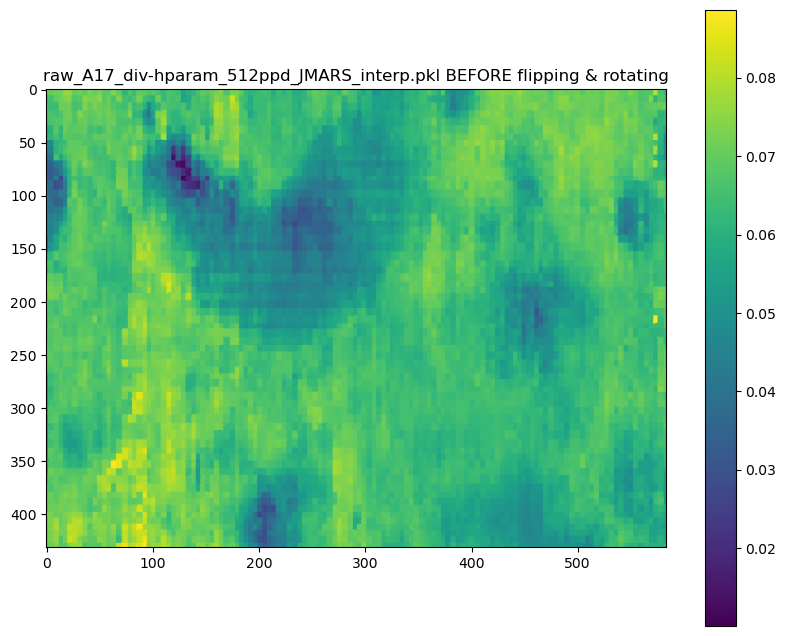

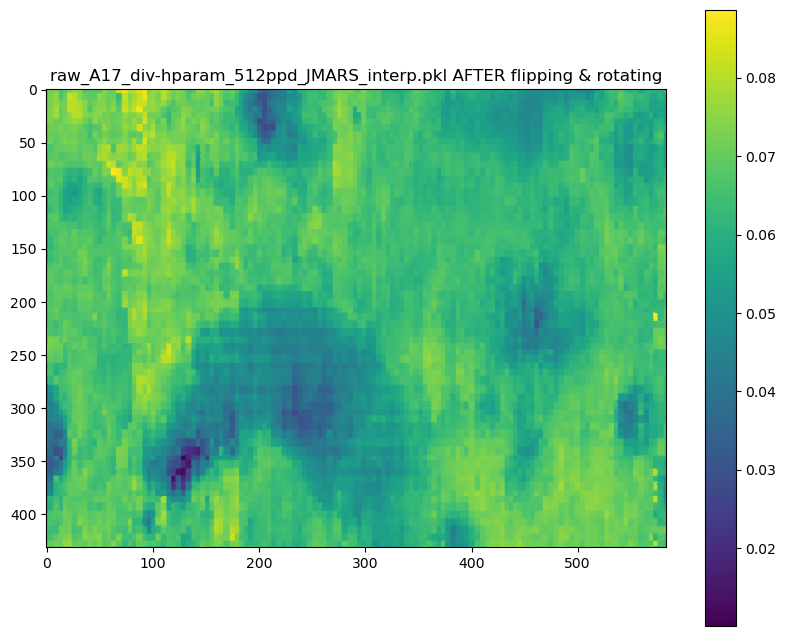

raw_A17_div-rockabun_2048ppd_JMARS_interp.pkl has shape: (3, 1798, 2354)


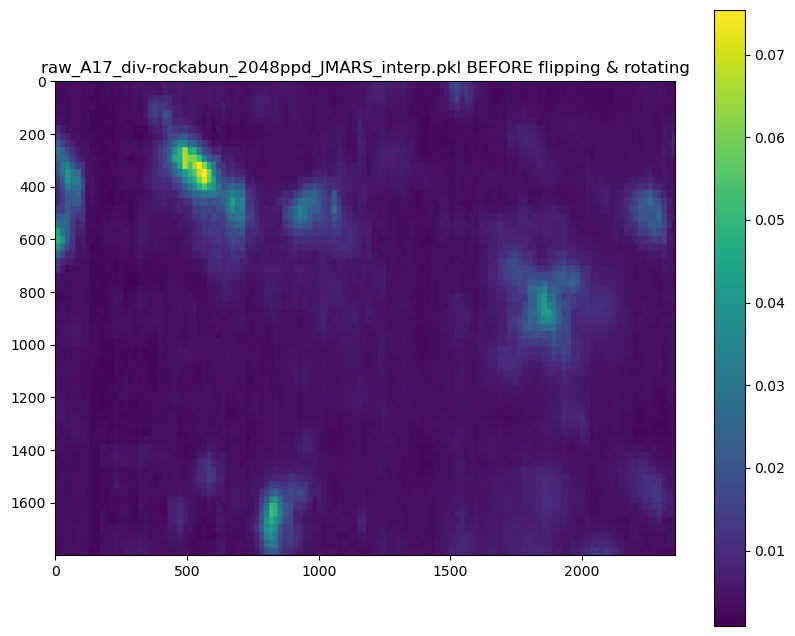

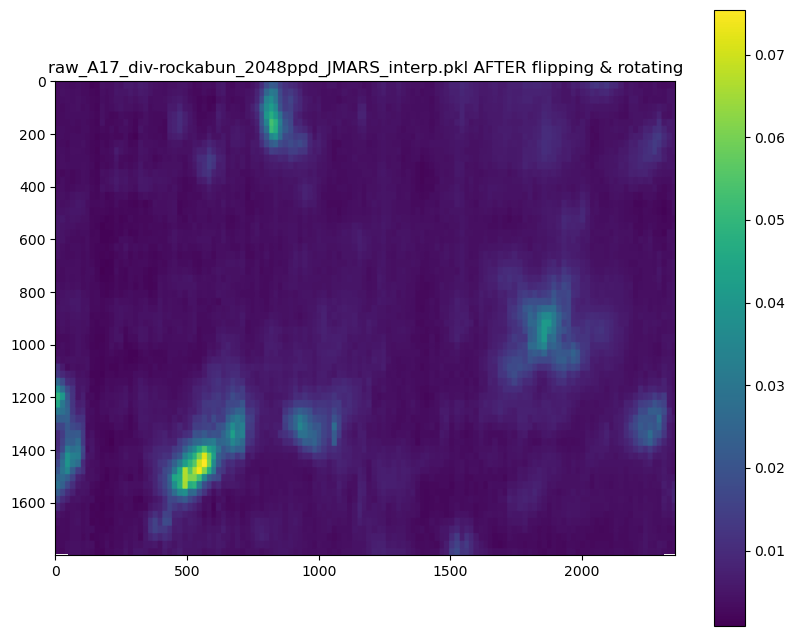

raw_A17_clem-omat_128ppd_JMARS_interp.pkl has shape: (3, 111, 148)


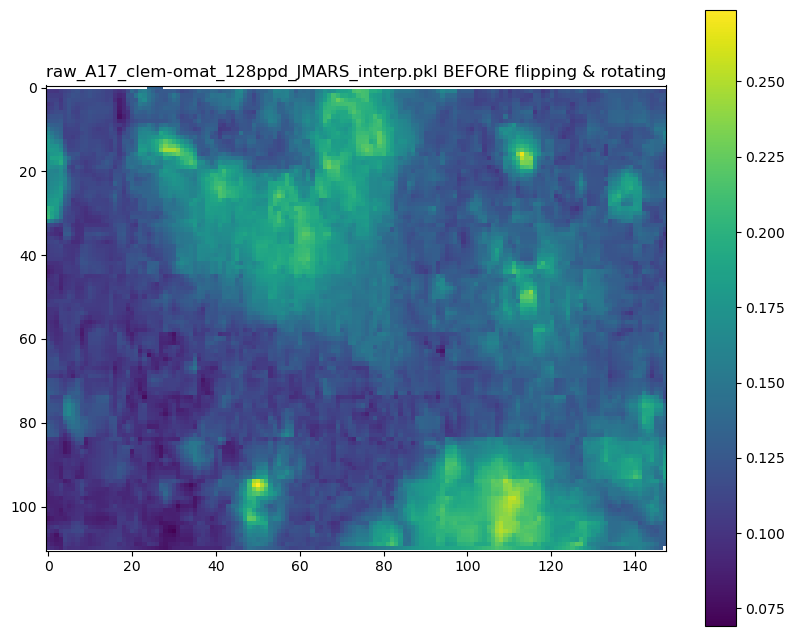

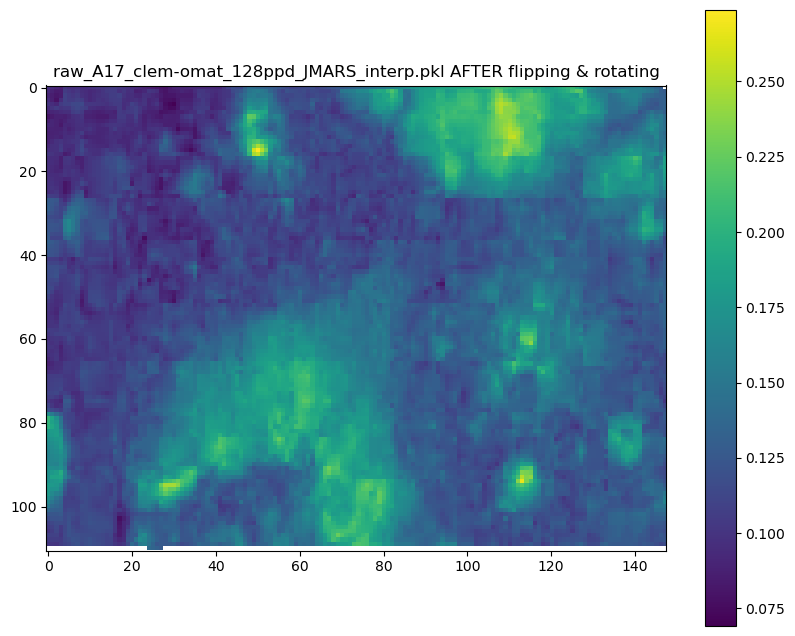

Data cube shape: (4, 3059, 6118, 1)
Made cube of pkl files
(4, 3059, 6118, 1)
NaN values in flattened data before imputation: 169456
NaN values in imputed data: 0
Scaled data
Applying k-means clustering algorithm
Finished clustering


In [7]:
print('Clustering our data cubes. Protocol 2, part 2: Combining image clusters with JMARS data')

directories = ['/explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/structures/A17/cutdata/']
print('The directories we are taking data from are:', directories)
max_shape = (0, 0, 0)
resized_data_all = []
pklcubes = []
pklfile_list = []

for directory in directories:
    # Load the .pkl files with the downloaded JMARS data
    for filename in os.listdir(directory):
        if filename.endswith('interp.pkl'):

            with open(os.path.join(directory, filename), 'rb') as f:
                data = pickle.load(f)
                print(filename, 'has shape:', np.shape(data))
                
                # Plotting cut data before flipping and rotating
                plot_layer(data[2][:][:], f'{filename} BEFORE flipping & rotating')
                
                # Rotating JMARS data by 180 degrees. We select to isolate layer 3, the only layer with data
                data = np.rot90(data[2][:][:], 2) 
                # Flipping JMARS data along the y axis
                data = np.fliplr(data)
                
                # Plotting data after it has been flipped and rotated
                plot_layer(data, f'{filename} AFTER flipping & rotating')
                
                pklfile_list.append(data)
                
                # Finding the largest dimension. This is what all arrays will be resized to
                max_shape = tuple(max(s1, s2) for s1, s2 in zip(max_shape, np.shape(data)))
                
    # Adding the cluster map created from the Kaguya imagery 
    pklfile_list.append(combined_cluster_map)
    max_shape = tuple(max(s1, s2) for s1, s2 in zip(max_shape, np.shape(combined_cluster_map)))

    # Resizing the cluster map to the size of the Kaguya dataset
    resized_data_list = [resize_array(data, max_shape) for data in pklfile_list]

    resized_data_all.append(resized_data_list)

    # Combine the data into a single data cube 
    pklfile_cube = np.stack(resized_data_all, axis=-1)
    print(f'Data cube shape: {pklfile_cube.shape}')
    pklcubes.append(pklfile_cube)
    print('Made cube of pkl files')

scaled_cubes = []
combined_scaled_data_cubes = []

for cube, directory in zip(pklcubes, directories):
    print(cube.shape)
    # Flatten the data cube for clustering
    num_datasets, num_rows, num_cols, _ = cube.shape

    flat_data = cube.reshape(num_datasets * num_rows * num_cols, -1)
    print(f'NaN values in flattened data before imputation: {np.isnan(flat_data).sum()}')

    # This is one way of removing NaNs from data. It takes a very long time to run.
    # imputer = KNNImputer(n_neighbors=3)
    # imputed_data = imputer.fit_transform(flat_data)
    
    # Replacing NaNs in flattened data with 0
    flat_data[np.isnan(flat_data)] = 0
    imputed_data = flat_data
    print(f'NaN values in imputed data: {np.isnan(imputed_data).sum()}')

    imputed_cube = imputed_data.reshape(cube.shape)

    # Standardizing the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(imputed_data)
    scaled_cubes.append(scaled_data)
    print('Scaled data')
    #print(scaled_data)
    combined_scaled_data = np.vstack(scaled_cubes)
    combined_scaled_data_cubes.append(combined_scaled_data)
    
    print('Applying k-means clustering algorithm')
    # Number of clusters
    num_clusters = 30
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(scaled_data)
    # Get the cluster labels
    cluster_labels = kmeans.labels_
    # Reshape cluster labels back to the original spatial dimensions
    cluster_labels_reshaped = cluster_labels.reshape(num_datasets, num_rows, num_cols)
    print('Finished clustering')

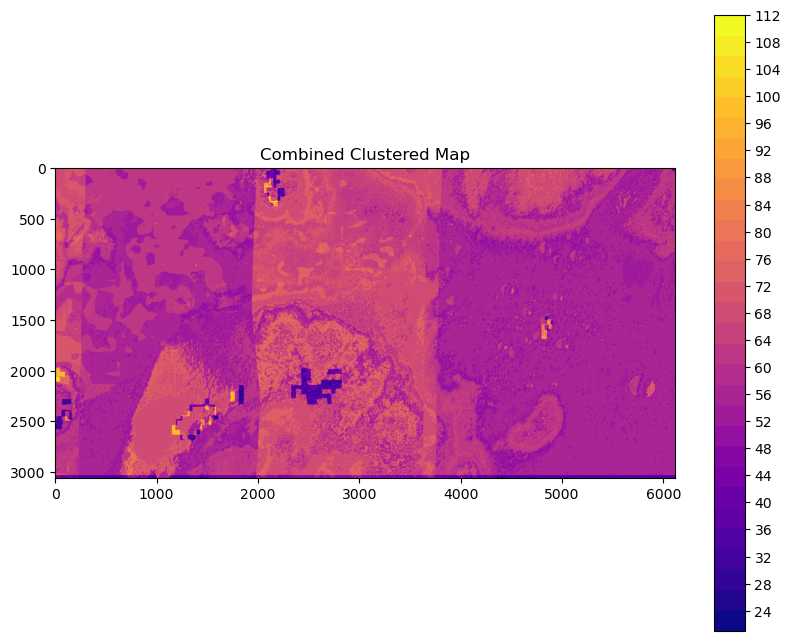

Combined k-means map saved as /explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/kmeans/A17/combined_clustered_map_30Clusters_Protocol2_Final_08-08.png


In [8]:
directory = '/explore/nobackup/people/mblancor/apollo_data_exploration/Data_AllSites/apollo_all/kmeans/A17/'
if not os.path.exists(directory):
    os.makedirs(directory)

combined_cluster_map = np.sum(cluster_labels_reshaped, axis=(0))

# Plotting the combined 2D k-means map
plt.figure(figsize=(10, 8))
plt.imshow(combined_cluster_map, cmap=plt.cm.get_cmap('plasma', num_clusters))

# (generate plot here)
cb = plt.colorbar()

# Adjust the number of ticks using MaxNLocator if needed
tick_locator = ticker.MaxNLocator(nbins=num_clusters-1)
cb.locator = tick_locator
cb.update_ticks()

plt.title('Combined Clustered Map')

# Save the plot
output_path = directory + 'combined_clustered_map_30Clusters_Protocol2_Final_08-08.png'
plt.savefig(output_path)
plt.show()
plt.close()
print(f'Combined k-means map saved as {output_path}')